In [1]:
import pandas as pd

data=pd.read_csv("D:\\DATA_science\\Data_sets\\Hamspam.csv",encoding='ISO-8859-1')

In [2]:
data.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or å£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


In [3]:
data.isnull().sum()

type    0
text    0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    5559 non-null   object
 1   text    5559 non-null   object
dtypes: object(2)
memory usage: 87.0+ KB


In [6]:
data.describe()

,type,text
count,5559,5559
unique,2,5156
top,ham,"Sorry, I'll call later"
freq,4812,30


## Data Cleaning

In [16]:
import re   # regular expression
import string

def clean_text(text):
    '''Make text lowercase, Remove text in square brackets, Remove punctations, Remove text with numbers...'''
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    text=re.sub("[0-9" "]+","",text)
    text=re.sub('[''""...]','',text)
    return text

clean=lambda x: clean_text(x)

In [17]:
data['text']=data.text.apply(clean)
data.text

0        hope you are having a good week just checking in
1                                    kgive back my thanks
2               am also doing in cbe only but have to pay
3       complimentary  star ibiza holiday or å£ cash n...
4       okmail dear dave this is your final notice to ...
                              ...                        
5554    you are a great role model you are giving so m...
5555    awesome i remember the last time we got somebo...
5556    if you dont your prize will go to another cust...
5557    sms ac jsco energy is high but u may not know ...
5558                      shall call now dear having food
Name: text, Length: 5559, dtype: object

In [18]:
# Word frequency
freq=pd.Series(' '.join(data['text']).split()).value_counts()[:20] # for top 20
freq

to      2243
i       2228
you     2118
a       1437
the     1323
u       1298
and      965
is       892
in       886
me       789
my       753
for      709
your     659
of       619
it       616
call     577
have     575
on       534
that     509
are      490
dtype: int64

In [20]:
# removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')
data['text']=data['text'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# word frequency after removal of stopwords
freq_Sw=pd.Series(' '.join(data['text']).split()).value_counts()[:20]
freq_Sw

u       1298
call     577
im       462
ur       389
get      384
å£       293
dont     287
go       282
ok       278
free     275
know     257
like     244
got      239
ill      239
good     236
come     228
time     214
day      203
love     197
send     191
dtype: int64

In [24]:
# countvectorizer tell the frequency of the word
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer=CountVectorizer(min_df=1,max_df=5)
X=vectorizer.fit_transform(data['text'])
word_freq_df=pd.DataFrame({'term':vectorizer.get_feature_names(),'occurances':np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency']=word_freq_df['occurances']/np.sum(word_freq_df['occurances'])

In [25]:
word_freq_df.head()

,term,occurances,frequency
0,aa,1,0.000089
1,aah,3,0.000266
2,aaniye,1,0.000089
3,aaooooright,1,0.000089
4,aathilove,3,0.000266


In [28]:
# TFIDF Term Fequency Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(stop_words='english',max_features=1000, max_df=0.5, smooth_idf=True) ## keep top 1000 words
doc_vec=vectorizer.fit_transform(data['text'])
names_features=vectorizer.get_feature_names()
dense=doc_vec.todense()
denselist=dense.tolist()
df=pd.DataFrame(denselist, columns=names_features)
df.head()

,abiola,able,abt,accept,access,account,actually,add,address,admirer,...,youve,yr,yrs,yup,ââ,ââèïs,ââèït,ûªs,ûªt,ûï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## N-gram

In [33]:
## bi-gram
def get_top_n2_words(corpus, n=None):
    vec1=CountVectorizer(ngram_range=(2,2),    ## for trigram keep ngram_range(3,3)
                        max_features=2000).fit(corpus)
    bag_of_words=vec1.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq=sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]


In [34]:
top2_words = get_top_n2_words(data["text"], n = 200) ## top 200 words
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ['Bi-gram', 'freq']
top2_df.head()

,Bi-gram,freq
0,please call,53
1,call later,50
2,ill call,48
3,let know,40
4,sorry ill,39


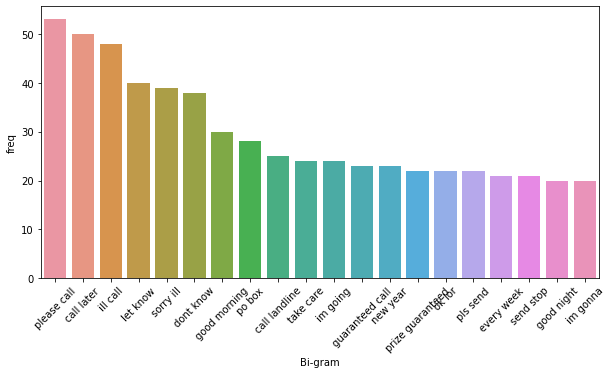

In [35]:
## Bigram plot
import matplotlib.pyplot as plt
import seaborn as sns
top20_bigram=top2_df.iloc[0:20,:]
fig = plt.figure(figsize=(10,5))
plot=sns.barplot(x = top20_bigram['Bi-gram'], y=top20_bigram["freq"])
plot.set_xticklabels(rotation=45, labels = top20_bigram['Bi-gram'])
plt.show()

In [40]:
# Tri-gram
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range = (3, 3), max_features=2000).fit(corpus)
    
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
top3_words = get_top_n3_words(data['text'], n = 200)
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Tri-gram", "Freq"]
top3_df.head()

,Tri-gram,Freq
0,ill call later,42
1,sorry ill call,38
2,prize guaranteed call,21
3,call land line,18
4,happy new year,18


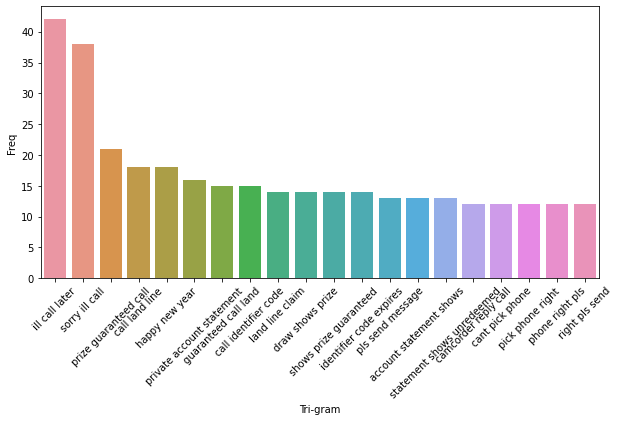

In [42]:
# trigram plot
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize=(10,5))
plot=sns.barplot(x=top20_trigram["Tri-gram"], y=top20_trigram["Freq"])
plot.set_xticklabels(rotation = 45, labels = top20_trigram["Tri-gram"])
plt.show()

## Wordcloud

In [43]:
string_total = ' '.join(data['text'])

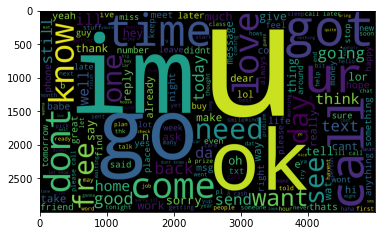

In [48]:
# wordcloud for entire corpus
from wordcloud import WordCloud
wordcloud_stw = WordCloud(background_color = 'black', width =  5000, height = 3000).generate(string_total)
plt.imshow(wordcloud_stw)

## Applying Naive Bayes for Classification

In [49]:
data.head()

,type,text
0,ham,hope good week checking
1,ham,kgive back thanks
2,ham,also cbe pay
3,spam,complimentary star ibiza holiday å£ cash needs...
4,spam,okmail dear dave final notice collect tenerife...


In [50]:
def split_into_words(i):
    return(i.split(" "))

In [51]:
from sklearn.model_selection import train_test_split
email_train,email_test = train_test_split(data, test_size = 0.3)

In [52]:
email_test

,type,text
35,ham,ron say fri leh n said ding tai feng cant make...
335,ham,ow u deyi paid told u would call
208,ham,ello babe u ok
4601,ham,thanks picking trash
5012,ham,hi dis yijue would happy work wif u
...,...,...
470,ham,nope im drivin neva develop da photos lei
889,spam,u win å£ music gift vouchers every week starti...
3568,ham,tirupur da started office call
5122,ham,great hear settling well whats happenin wit ola


In [54]:
## Preparing email text into word count matrix format
emails_bow = CountVectorizer(analyzer = split_into_words).fit(data.text)

In [55]:
# for all messages
all_emails_matrix = emails_bow.transform(data.text)
all_emails_matrix.shape

(5559, 8175)

In [60]:
# for training messages
email_train_matrix = emails_bow.transform(email_train.text)
email_train_matrix.shape

(3891, 8175)

In [61]:
email_test_matrix = emails_bow.transform(email_test.text)
email_test_matrix.shape

(1668, 8175)

In [62]:
###########WIthout TFIDF matrices################
# preparing naive bayes model on training dataset

from sklearn.naive_bayes import MultinomialNB as MB

# multinomial naive bayes
classifier_mb = MB()

classifier_mb.fit(email_train_matrix, email_train.type )

MultinomialNB()

In [63]:
train_pred_m = classifier_mb.predict(email_train_matrix)
accuracy_train_m = np.mean(train_pred_m==email_train.type) # 98%
accuracy_train_m

0.9886918529940889

In [64]:
test_pred_m = classifier_mb.predict(email_test_matrix)
accuracy_test_m = np.mean(test_pred_m==email_test.type) # 96%

In [65]:
accuracy_test_m

0.9676258992805755

## Using TFIDF

In [67]:
from sklearn.feature_extraction.text import TfidfTransformer

# Learning Term weighting and normalizing on entire emails
tfidf_transformer = TfidfTransformer().fit(all_emails_matrix)

# Preparing TFIDF for train emails
train_tfidf = tfidf_transformer.transform(email_train_matrix)

train_tfidf.shape # (3891, 6661)

# Preparing TFIDF for test emails
test_tfidf = tfidf_transformer.transform(email_test_matrix)

test_tfidf.shape #  (1668, 6661)



(1668, 8175)

In [68]:
test_tfidf

<1668x8175 sparse matrix of type '<class 'numpy.float64'>'
	with 13856 stored elements in Compressed Sparse Row format>

In [69]:
# Preparing a naive bayes model on training data set 

from sklearn.naive_bayes import MultinomialNB as MB


# Multinomial Naive Bayes
classifier_mb = MB()
classifier_mb.fit(train_tfidf,email_train.type)
train_pred_m = classifier_mb.predict(train_tfidf)
accuracy_train_m = np.mean(train_pred_m==email_train.type) # 96%

test_pred_m = classifier_mb.predict(test_tfidf)
accuracy_test_m = np.mean(test_pred_m==email_test.type) # 96%

In [70]:
accuracy_train_m

0.9714726291441789

In [71]:
accuracy_test_m

0.9640287769784173